# Example of rasterio.vrt.WarpedVRT integration with xarray.open_rasterio

*The point here is to do on-the-fly reprojection when data is moved from cloud storage into local RAM*

In [1]:
import rasterio
from rasterio.vrt import WarpedVRT
import xarray as xr
import pyproj 

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

In [2]:
xr.show_versions()


INSTALLED VERSIONS
------------------
commit: 35c5afbc46a84c1e12031e2cc9a21445a7bab9a5
python: 3.6.7 | packaged by conda-forge | (default, Nov 20 2018, 18:20:05) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)]
python-bits: 64
OS: Darwin
OS-release: 18.2.0
machine: x86_64
processor: i386
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8
libhdf5: 1.10.3
libnetcdf: 4.6.1

xarray: 0.11.0+11.g35c5afbc
pandas: 0.23.4
numpy: 1.15.1
scipy: 1.1.0
netCDF4: 1.4.2
pydap: installed
h5netcdf: 0.6.2
h5py: 2.8.0
Nio: None
zarr: 2.2.0
cftime: 1.0.2.1
PseudonetCDF: None
rasterio: 1.0.11
cfgrib: installed
iris: None
bottleneck: 1.2.1
cyordereddict: None
dask: 1.0.0
distributed: 1.25.0
matplotlib: 2.2.3
cartopy: None
seaborn: 0.9.0
setuptools: 40.6.2
pip: 18.1
conda: None
pytest: 4.0.1
IPython: 7.2.0
sphinx: None


In [3]:
# Lansat8 is a public dataset on Google Cloud
# Stored as tiles geotiff in UTM CRS, 30m posting
url = 'https://storage.googleapis.com/\
gcp-public-data-landsat/LC08/01/047/027/\
LC08_L1TP_047027_20130421_20170310_01_T1/\
LC08_L1TP_047027_20130421_20170310_01_T1_B4.TIF'

In [4]:
# rasterio uses an environment context manager
env = rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
          CPL_VSIL_CURL_USE_HEAD=False,
          CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF')

## Load rasterio vrt object with open_rasterio

In [5]:
# Lazy in-memory warping from UTM to WGS84 lat/lon
with env:
    with rasterio.open(url) as src:
        print(src.profile)
        with WarpedVRT(src, crs='epsg:4326') as vrt:
            print(vrt.profile)
            with xr.open_rasterio(vrt) as da:
                print(da)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7751, 'height': 7531, 'count': 1, 'crs': CRS({'init': 'epsg:32610'}), 'transform': Affine(30.0, 0.0, 356685.0,
       0.0, -30.0, 5367615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'VRT', 'dtype': 'uint16', 'nodata': None, 'width': 9183, 'height': 5981, 'count': 1, 'crs': CRS({'init': 'epsg:4326', 'no_defs': True}), 'transform': Affine(0.000342425323647155, 0.0, -124.93801050800107,
       0.0, -0.000342425323647155, 48.46166943472688), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}
<xarray.DataArray (band: 1, y: 5981, x: 9183)>
[54923523 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 48.46 48.46 48.46 48.46 ... 46.41 46.41 46.41 46.41
  * x        (x) float64 -124.9 -124.9 -124.9 -124.9 ... -121.8 -121.8 -121.8
Attributes:
    transform:   (0.000342425323647155, 0.0, -124.93801050800107, 0.0, -0.000...
    

## Pull subset of image (10km x 20km pixel box in center of image)

469650.0 5251350.0
<xarray.DataArray (band: 1, y: 7531, x: 7751)>
[58372781 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.368e+06 5.368e+06 5.368e+06 ... 5.142e+06 5.142e+06
  * x        (x) float64 3.567e+05 3.567e+05 3.568e+05 ... 5.892e+05 5.892e+05
Attributes:
    transform:   (30.0, 0.0, 356685.0, 0.0, -30.0, 5367615.0)
    crs:         +init=epsg:32610
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)


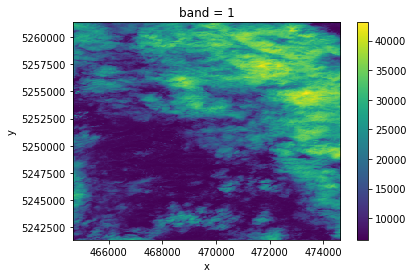

In [6]:
# Unprojected
with env:
    with rasterio.open(url) as src:
        xcen, ycen = src.width//2, src.height//2
        east, north = src.xy(xcen,ycen)
        utm = pyproj.Proj(src.crs) #we'll use this later to convert coordinates
        print(east, north)
        da = xr.open_rasterio(src)
print(da)
#da.isel(dict(band=0, x=slice(xcen-250, xcen+250), y=slice(ycen-500, ycen+500))).plot.imshow(center=False)
#Note slice starts w/ north +10 since dy=-30
da.sel(band=1, x=slice(east-5e3, east+5e3), y=slice(north+10e3, north-10e3)).plot.imshow(center=False)

In [7]:
# convert our bounds to wgs84
ul = (east-5e3,north+10e3)
lr = (east+5e3,north-10e3)
left, top = utm(*ul, inverse=True)
right, bottom = utm(*lr, inverse=True)
print(left, right, bottom, top)

-123.46941343450654 -123.33548109903441 47.325127998331794 47.50462040692757


<xarray.DataArray (band: 1, y: 5981, x: 9183)>
[54923523 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 48.46 48.46 48.46 48.46 ... 46.41 46.41 46.41 46.41
  * x        (x) float64 -124.9 -124.9 -124.9 -124.9 ... -121.8 -121.8 -121.8
Attributes:
    transform:   (0.000342425323647155, 0.0, -124.93801050800107, 0.0, -0.000...
    crs:         +init=epsg:4326 +no_defs
    res:         (0.000342425323647155, 0.000342425323647155)
    is_tiled:    1
    nodatavals:  (nan,)


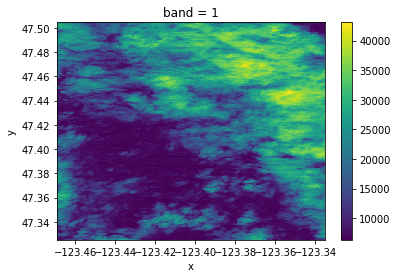

In [8]:
# Projected
# Use geopandas to get the window bounds
with env:
    with rasterio.open(url) as src:
        with WarpedVRT(src, crs='epsg:4326') as vrt:
            da = xr.open_rasterio(vrt)

print(da)
da.sel(band=1, x=slice(left, right), y=slice(top, bottom)).plot.imshow(center=False)

## Save subset to geotiff

In [9]:

with env:
    with rasterio.open(url) as src:
        profile = src.profile.copy()
        with WarpedVRT(src, crs='epsg:4326') as vrt:
            da = xr.open_rasterio(vrt)
            
            # Do xarray processing here!
            subset = da.sel(band=1, x=slice(left, right), y=slice(top, bottom))
            subset = subset.where(subset<15e3, 0) #keep only values less than 15e3
            data = subset.data
        
            window = rasterio.windows.from_bounds(left, bottom, right, top, vrt.transform)

            profile.update({
                'driver': 'GTiff',
                'height': window.height,
                'width': window.width,
                'transform': vrt.window_transform(window)})
            
            with rasterio.open('test.tif', 'w', **profile) as dst:
                dst.write_band(1, data)

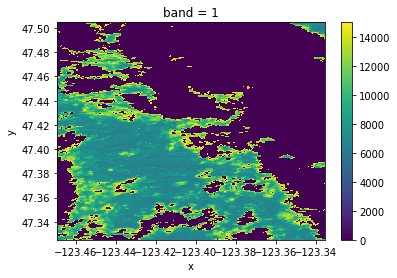

In [10]:
with env:
    da = xr.open_rasterio('test.tif')
da.sel(band=1).plot.imshow()

## Try with dask distributed

In [11]:
from dask.distributed import Client, progress
client = Client()
client

Client Scheduler: tcp://127.0.0.1:58393 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [12]:
# Lazy in-memory warping from UTM to WGS84 lat/lon
with env:
    with rasterio.open(url) as src:
        print(src.profile)
        with WarpedVRT(src, crs='epsg:4326') as vrt:
            print(vrt.profile)
            with xr.open_rasterio(vrt, chunks=dict(band=1, x=128, y=128)) as da:
                print(da)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7751, 'height': 7531, 'count': 1, 'crs': CRS({'init': 'epsg:32610'}), 'transform': Affine(30.0, 0.0, 356685.0,
       0.0, -30.0, 5367615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'VRT', 'dtype': 'uint16', 'nodata': None, 'width': 9183, 'height': 5981, 'count': 1, 'crs': CRS({'init': 'epsg:4326', 'no_defs': True}), 'transform': Affine(0.000342425323647155, 0.0, -124.93801050800107,
       0.0, -0.000342425323647155, 48.46166943472688), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}
<xarray.DataArray (band: 1, y: 5981, x: 9183)>
dask.array<shape=(1, 5981, 9183), dtype=uint16, chunksize=(1, 128, 128)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 48.46 48.46 48.46 48.46 ... 46.41 46.41 46.41 46.41
  * x        (x) float64 -124.9 -124.9 -124.9 -124.9 ... -121.8 -121.8 -121.8
Attributes:
    transform:   (0.000342425323647155, 0.0, -12

In [13]:
# Unprojected
with env:
    with rasterio.open(url) as src:
        xcen, ycen = src.width//2, src.height//2
        east, north = src.xy(xcen,ycen)
        utm = pyproj.Proj(src.crs) #we'll use this later to convert coordinates
        print(east, north)
        da = xr.open_rasterio(src, chunks=dict(band=1, x=512, y=512))
print(da)
#da.isel(dict(band=0, x=slice(xcen-250, xcen+250), y=slice(ycen-500, ycen+500))).plot.imshow(center=False)
#Note slice starts w/ north +10 since dy=-30
subset = da.sel(band=1, x=slice(east-5e3, east+5e3), y=slice(north+10e3, north-10e3)).persist()
print(subset)
x = subset.persist()
progress(subset)

469650.0 5251350.0
<xarray.DataArray (band: 1, y: 7531, x: 7751)>
dask.array<shape=(1, 7531, 7751), dtype=uint16, chunksize=(1, 512, 512)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.368e+06 5.368e+06 5.368e+06 ... 5.142e+06 5.142e+06
  * x        (x) float64 3.567e+05 3.567e+05 3.568e+05 ... 5.892e+05 5.892e+05
Attributes:
    transform:   (30.0, 0.0, 356685.0, 0.0, -30.0, 5367615.0)
    crs:         +init=epsg:32610
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)
<xarray.DataArray (y: 667, x: 333)>
dask.array<shape=(667, 333), dtype=uint16, chunksize=(42, 333)>
Coordinates:
    band     int64 1
  * y        (y) float64 5.261e+06 5.261e+06 5.261e+06 ... 5.241e+06 5.241e+06
  * x        (x) float64 4.647e+05 4.647e+05 4.647e+05 ... 4.746e+05 4.746e+05
Attributes:
    transform:   (30.0, 0.0, 356685.0, 0.0, -30.0, 5367615.0)
    crs:         +init=epsg:32610
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)


VBox()

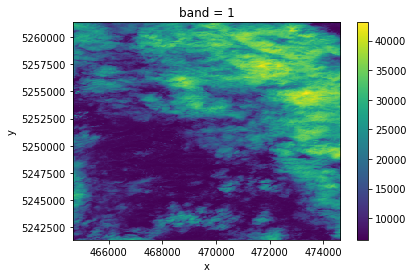

In [14]:
subset.plot.imshow(center=False)

In [15]:
# Projected
# Use geopandas to get the window bounds
with env:
    with rasterio.open(url) as src:
        with WarpedVRT(src, crs='epsg:4326') as vrt:
            da = xr.open_rasterio(vrt, chunks=dict(band=1, x=512, y=512))

print(da)
subset = da.sel(band=1, x=slice(left, right), y=slice(top, bottom)).persist()
print(subset)
progress(subset)

<xarray.DataArray (band: 1, y: 5981, x: 9183)>
dask.array<shape=(1, 5981, 9183), dtype=uint16, chunksize=(1, 512, 512)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 48.46 48.46 48.46 48.46 ... 46.41 46.41 46.41 46.41
  * x        (x) float64 -124.9 -124.9 -124.9 -124.9 ... -121.8 -121.8 -121.8
Attributes:
    transform:   (0.000342425323647155, 0.0, -124.93801050800107, 0.0, -0.000...
    crs:         +init=epsg:4326 +no_defs
    res:         (0.000342425323647155, 0.000342425323647155)
    is_tiled:    1
    nodatavals:  (nan,)
<xarray.DataArray (y: 524, x: 391)>
dask.array<shape=(524, 391), dtype=uint16, chunksize=(277, 319)>
Coordinates:
    band     int64 1
  * y        (y) float64 47.5 47.5 47.5 47.5 47.5 ... 47.33 47.33 47.33 47.33
  * x        (x) float64 -123.5 -123.5 -123.5 -123.5 ... -123.3 -123.3 -123.3
Attributes:
    transform:   (0.000342425323647155, 0.0, -124.93801050800107, 0.0, -0.000...
    crs:         +init=epsg:4326 +no_defs
    res:         (

VBox()

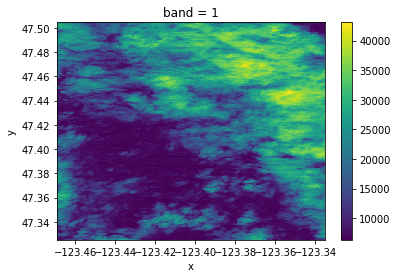

In [16]:
subset.plot.imshow(center=False)

### Seems to be working!..

Question: Is each open_rasterio-getitem aware of the rasterio.Env() context manager?